In [ ]:
#!/usr/bin/env python3
"""
plot_sr_plus_energy_levels.py

Load Sr⁺ energy‐level data, optionally apply a Zeeman split,
configure layout and style, and plot the level diagram with transitions.
"""

import json
from pathlib import Path
from energy_level_generator.models import Level
from energy_level_generator.read import load_ion_data
from energy_level_generator.splitters import ZeemanSplitter, SidebandSplitter
from energy_level_generator.layout import LayoutConfig
from energy_level_generator.style import StyleConfig
from energy_level_generator.plotter import plot_energy_levels

from dataclasses import is_dataclass
from typing import Any
from energy_level_generator.models import Level  # for isinstance checks


def plot(path):
    # ─── 1) Load the raw JSON file into our data structure ────────────────────
    # The JSON must contain keys: "ion", "unit", "levels", and optional "transitions".
    # Each level entry is passed through Level(**entry) to create Level objects.
    data_path = Path(str(path))
    raw = json.loads(data_path.read_text())
    levels = [Level(**entry) for entry in raw["levels"]]
    data = {
        "ion": raw.get("ion", ""),
        "unit": raw.get("unit", "cm⁻¹"),
        "levels": levels,
        "transitions": raw.get("transitions", []),
        "title": raw.get("title", ""),
    }

    # ─── 2) (Optional) Apply a small Zeeman splitting to the levels ───────────
    # This will take each Level and produce sub‐levels with m‐quantum ticks.
    # 1) configure splitters
    zs = ZeemanSplitter(b_tesla=0.01)  # Tesla
    sb = SidebandSplitter(gap=10000)  # cm^-1 (matches your docstring)

    # 2) take a snapshot of the ORIGINAL levels so you don't mutate while iterating
    orig_levels = list(data["levels"])

    # 3) build the new list: keep each original level, then add its children
    split_levels = []
    for lvl in orig_levels:
        split_levels.append(lvl)  # keep the parent/base

        # 1) make Zeeman children first
        zkids = zs.split(lvl)  # returns List[Level]
        split_levels.extend(zkids)

        # 2) make sidebands ATTACHED TO THE RIGHT ZEEMAN CHILD
        sbkids = sb.split(lvl, zeeman_children=zkids)  # <-- new arg
        split_levels.extend(sbkids)

    # 4) replace the levels list once
    data["levels"] = split_levels

    def _sanitize(x: Any):
        """Make nested structures JSON-safe; replace dataclass Levels with their labels."""
        if isinstance(x, Level):
            return x.label
        if isinstance(x, dict):
            return {k: _sanitize(v) for k, v in x.items()}
        if isinstance(x, (list, tuple, set)):
            return [_sanitize(v) for v in x]
        # fall back to plain value / repr for non-JSON types
        try:
            json.dumps(x)
            return x
        except TypeError:
            return repr(x)

    def level_to_shallow_dict(lvl: Level):
        return {
            "label": lvl.label,
            "energy": lvl.energy,
            "zeeman": lvl.zeeman,  # keep your field name as defined
            "sideband": _sanitize(lvl.sideband),
            "sublevel": lvl.sublevel,
            "parent": (
                lvl.parent.label if isinstance(lvl.parent, Level) else lvl.parent
            ),
            "split_type": lvl.split_type,
            "children": [
                (c.label if isinstance(c, Level) else c) for c in (lvl.children or [])
            ],
            "meta": _sanitize(lvl.meta),
        }

    def dump_levels(levels, *, sort=True, outfile=None, indent=2):
        items = list(levels)
        if sort:
            items.sort(
                key=lambda l: (getattr(l, "energy", 0.0), getattr(l, "label", ""))
            )
        payload = [level_to_shallow_dict(l) for l in items]
        text = json.dumps(payload, indent=indent)
        print(text)
        if outfile:
            with open(outfile, "w", encoding="utf-8") as f:
                f.write(text)

    # Pretty-print all levels (call after you set data["levels"])
    dump_levels(data["levels"])
    # dump_levels(data["levels"], outfile="levels_dump.json")

    # ─── 3) Build the layout configuration ────────────────────────────────────
    # - column_letters & positions determine horizontal grouping (S, P, D, F → columns)
    # - spacing: base horizontal distance between columns
    # - bar_half: half‐width of each energy bar
    # - x_jitter: maximum horizontal jitter for sub‐levels around parent
    # - y_jitter: base vertical jitter for stacking levels
    # - energy_group_key: function to bucket levels into fine‐structure groups
    # - energy_group_y_scale: multiplier for vertical fan of base-level groups
    # - sublevel_y_scale: multiplier for extra vertical separation of sub‐levels
    layout = LayoutConfig(
        column_letters=["S1/2", "P1/2", "P3/2", "D3/2", "D5/2"],
        column_positions=[0, 0, 1, 2, 2],
        spacing=1,
        bar_half=0.3,
        x_jitter=0.25,
        y_jitter=100.0,
        energy_group_key=lambda lvl: int(lvl.energy // 10000),
        energy_group_y_scale=30,
        sublevel_uniform_spacing=1000.0,  # distance between adjacent sublevels
        sublevel_uniform_centered=True,  # whether to center around parent
    )

    # ─── 4) Build the style configuration ─────────────────────────────────────
    # StyleConfig defines colors, line widths, tick sizes, etc.
    style = StyleConfig()
    style.hide_split_types = {"sideband"}  # already using this
    style.show_qnum_header = True  # draw one header per parent
    style.qnum_header_pad_factor = (
        0.70  # × cfg.sublevel_uniform_spacing above top value
    )
    style.zeeman_label_value_only = True  # strip "m_j=" prefix on each value
    style.qnum_header_x_shift = 0.015  # try 0.04–0.10 (x-axis units)
    style.qnum_value_x_shift = 0.00
    # optional: use a monospaced font for tighter alignment
    style.sublevel_value_fontfamily = "DejaVu Sans Mono"

    # ─── 5) Plot the diagram ──────────────────────────────────────────────────
    # - data: contains ion name, unit, levels, transitions
    # - layout: controls bar/tick placement
    # - style: controls colors and line widths
    # - show_axis=True draws the y‐axis; set to False to hide it
    plot_energy_levels(data, layout, style, show_axis=False)

[
  {
    "label": "5s  2S1/2, m_j=-1/2",
    "energy": -0.004668644771929822,
    "zeeman": false,
    "sideband": null,
    "sublevel": 1,
    "parent": "5s  2S1/2",
    "split_type": "zeeman",
    "children": [],
    "meta": {}
  },
  {
    "label": "5s  2S1/2",
    "energy": 0.0,
    "zeeman": true,
    "sideband": null,
    "sublevel": 0,
    "parent": null,
    "split_type": null,
    "children": [
      "5s  2S1/2, m_j=-1/2",
      "5s  2S1/2, m_j=+1/2"
    ],
    "meta": {}
  },
  {
    "label": "5s  2S1/2, m_j=+1/2",
    "energy": 0.004668644771929822,
    "zeeman": false,
    "sideband": null,
    "sublevel": 1,
    "parent": "5s  2S1/2",
    "split_type": "zeeman",
    "children": [],
    "meta": {}
  },
  {
    "label": "4d  2D5/2, m_j=-5/2, red sideband",
    "energy": 4994.985994065684,
    "zeeman": false,
    "sideband": null,
    "sublevel": 2,
    "parent": "4d  2D5/2, m_j=-5/2",
    "split_type": "sideband",
    "children": [],
    "meta": {}
  },
  {
    "label": "4

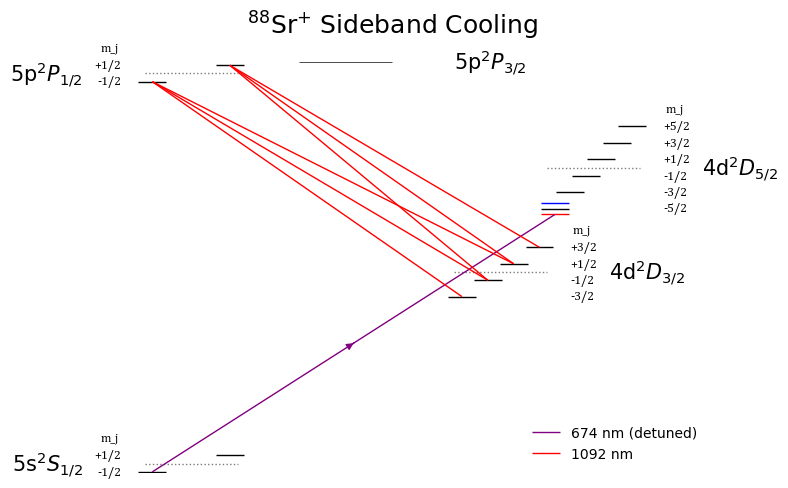

In [2]:
plot("energy_level_generator/data/SrSidebandCooling.json")